#  Обнаружение объектов

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы: 
* https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
* https://pyimagesearch.com/2021/11/01/training-an-object-detector-from-scratch-in-pytorch/
* https://pyimagesearch.com/2021/08/02/pytorch-object-detection-with-pre-trained-networks/

## Задачи для совместного разбора

1\. Рассмотрите простейшую архитектуру для решения задачи object detection и процесс настройки модели.

In [1]:
import os
import random
from typing import Callable, Dict, List, Optional, Tuple

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split

import torchvision.models as models
from torchvision import transforms
import torchvision.transforms.functional as TF
from torchvision.transforms.functional import to_pil_image

from PIL import Image
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

device = torch.device(
    "mps" if torch.mps.is_available()
    else ("cuda" if torch.cuda.is_available() else "cpu")
)

RESNET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
RESNET_STD = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
IMG_EXTS = (".jpg", ".jpeg", ".png", ".bmp", ".webp")

def denormalize(img_tensor: torch.Tensor) -> torch.Tensor:
    mean = RESNET_MEAN.to(img_tensor.device)
    std = RESNET_STD.to(img_tensor.device)
    return torch.clamp(img_tensor * std + mean, 0, 1)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as tvm

device


device(type='mps')

## Задачи для самостоятельного решения

<p class="task" id="1"></p>

1\. Напишите функцию `parse_xml`, которая читает xml-файл с разметкой изображения из архива `animals.zip` и возвращает словарь, содержащий три ключа: 
```
{
        "raw": # словарь с ключами xmin, ymin, xmax, ymax
        "scaled": # словарь с ключами xmin, ymin, xmax, ymax
        "obj_name": # строка
}
```
В этом словаре `row` - абсолютные значения координат вершин bounding box, а `scaled` - относительные (нормированные на ширину и высоту изображения). Примените функцию к файлу `cat.0.xml` и выведите результат на экран.


- [ ] Проверено на семинаре

In [2]:
from typing import Dict
import xml.etree.ElementTree as ET
import os

def parse_xml(xml_path: str) -> Dict[str, Dict[str, float] | str]:
    tree = ET.parse(xml_path)
    root = tree.getroot()

    size = root.find("size")
    W = int(float(size.find("width").text))
    H = int(float(size.find("height").text))

    obj = root.find("object")
    name = obj.find("name").text
    bb = obj.find("bndbox")

    def _num(tag: str) -> float:
        return float(bb.find(tag).text)

    x1, y1, x2, y2 = _num("xmin"), _num("ymin"), _num("xmax"), _num("ymax")

    raw = {
        "xmin": int(round(x1)),
        "ymin": int(round(y1)),
        "xmax": int(round(x2)),
        "ymax": int(round(y2)),
    }
    scaled = {
        "xmin": x1 / W,
        "ymin": y1 / H,
        "xmax": x2 / W,
        "ymax": y2 / H,
    }
    return {"raw": raw, "scaled": scaled, "obj_name": name}



<p class="task" id="2"></p>

2\. Опишите датасет `AnimalDetectionDataset` на основе архива `animals.zip`. Реализуйте `__getitem__` таким образом, чтобы он возвращал три элемента: тензор с изображением, словарь с координатами bounding box и метку объекта. Предусмотрите возможность передавать извне при создании датасета набор преобразований для изображений, преобразование для метки объекта (для кодирования) и флаг, показывающий, нужно ли возвращать исходные или нормированные координаты bounding box.

- [ ] Проверено на семинаре

In [ ]:
class AnimalDetectionDataset(Dataset):
    def __init__(self, 
                 root: str,
                 transforms: Optional[Callable] = None,
                 target_transform: Optional[Callable] = None,
                 return_scaled: bool = True):
        self.root = root
        self.transforms = transforms
        self.target_transform = target_transform
        self.return_scaled = return_scaled
        
        self.pairs = self._create_pairs()

    def _create_pairs(self) -> List[Tuple[str, str]]:
        pairs = []
        
        xml_files = {}
        for file in os.listdir(self.root):
            if file.endswith('.xml'):
                stem = os.path.splitext(file)[0]
                xml_files[stem] = os.path.join(self.root, file)
        
        for file in os.listdir(self.root):
            stem, ext = os.path.splitext(file)
            if ext.lower() in ['.jpg', '.jpeg', '.png', '.bmp']:
                if stem in xml_files:
                    img_path = os.path.join(self.root, file)
                    xml_path = xml_files[stem]
                    pairs.append((img_path, xml_path))
        
        return pairs

    def __len__(self) -> int:
        return len(self.pairs)

    def __getitem__(self, idx: int):
        img_path, xml_path = self.pairs[idx]
        img = Image.open(img_path).convert("RGB")
        img = self.transforms(img) if self.transforms else TF.to_tensor(img)
        ann = parse_xml(xml_path)
        bbox = ann["scaled" if self.return_scaled else "raw"]
        label = ann["obj_name"]
        if self.target_transform:
            label = self.target_transform(label)
        return img, bbox, label


<p class="task" id="3"></p>

3\. Создайте объект класса `AnimalDetectionDataset` без применения преобразований и со значением `return_scaled=False`. Напишите функцию `show_image_with_bounding_box` для визуализации изображения с добавлением на него bounding box и подписи объекта. Продемонстрируйте работу функцию на изображении собаки и кошки.

- [ ] Проверено на семинаре

Найдено 1100 пар изображение-аннотация
Нашли 548 кошек и 552 собак
Случайная кошка (index=680): {'xmin': 6, 'ymin': 111, 'xmax': 263, 'ymax': 370}


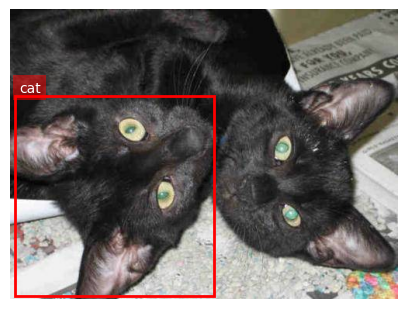

Случайная собака (index=964): {'xmin': 15, 'ymin': 15, 'xmax': 211, 'ymax': 367}


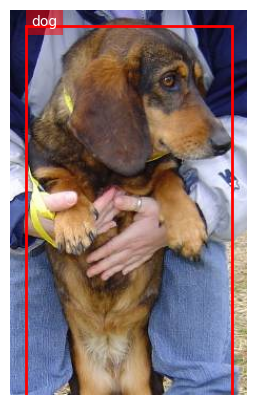

In [ ]:
ds = AnimalDetectionDataset(
    root="./data/Asirra: cat vs dogs",  
    transforms=None,
    target_transform=None,
    return_scaled=False,
)# создаём датасет без трансформаций и с абсолютными координатами


def show_image_with_bounding_box(img_tensor, bbox_dict, label):
    img = to_pil_image(img_tensor)
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(img)
    ax.axis("off")

    x1, y1 = bbox_dict["xmin"], bbox_dict["ymin"]
    x2, y2 = bbox_dict["xmax"], bbox_dict["ymax"]
    rect = Rectangle((x1, y1), x2 - x1, y2 - y1,
                     fill=False, edgecolor="red", linewidth=2)
    ax.add_patch(rect)
    ax.text(x1 + 5, max(15, y1 - 5), str(label), color="white",
            bbox=dict(facecolor="red", alpha=0.5, edgecolor="none"))

    plt.show()

cat_indices = [i for i in range(len(ds)) if isinstance(ds[i][2], str) and ds[i][2].lower().startswith("cat")]
dog_indices = [i for i in range(len(ds)) if isinstance(ds[i][2], str) and ds[i][2].lower().startswith("dog")]

print(f"Нашли {len(cat_indices)} кошек и {len(dog_indices)} собак")

if cat_indices:
    idx_cat = random.choice(cat_indices)
    img_c, bbox_c, label_c = ds[idx_cat]
    print(f"Случайная кошка (index={idx_cat}):", bbox_c)
    show_image_with_bounding_box(img_c, bbox_c, label_c)

if dog_indices:
    idx_dog = random.choice(dog_indices)
    img_d, bbox_d, label_d = ds[idx_dog]
    print(f"Случайная собака (index={idx_dog}):", bbox_d)
    show_image_with_bounding_box(img_d, bbox_d, label_d)


<p class="task" id="4"></p>

4\. Напишите модель для решения задачи выделения объектов. Реализуйте двухголовую сеть, одна голова которой предсказывает метку объекта (задача классификации), а вторая голова предсказывает 4 координаты вершин bounding box (задача регрессии). В качестве backbone используйте модель resnet50 из пакета `torchvision`.

- [ ] Проверено на семинаре

In [ ]:

class DetectionNet(nn.Module):
    def __init__(self, num_classes: int, pretrained: bool = True, freeze_backbone: bool = False):
        super().__init__()
        if pretrained:
            try:
                backbone = tvm.resnet50(weights=tvm.ResNet50_Weights.IMAGENET1K_V2)
            except AttributeError:
                backbone = tvm.resnet50(pretrained=True)
        else:
            backbone = tvm.resnet50(weights=None)

        self.backbone = nn.Sequential(*(list(backbone.children())[:-1]))  # -> (B, 2048, 1, 1)
        self.out_feat_dim = 2048

        if freeze_backbone:
            for p in self.backbone.parameters():
                p.requires_grad = False

        self.cls_head = nn.Linear(self.out_feat_dim, num_classes)
        self.box_head = nn.Linear(self.out_feat_dim, 4)

        nn.init.normal_(self.cls_head.weight, std=0.01)
        nn.init.constant_(self.cls_head.bias, 0.)
        nn.init.normal_(self.box_head.weight, std=0.001)
        nn.init.constant_(self.box_head.bias, 0.)

    def forward(self, x):
        # x: (B, 3, H, W); resnet50 -> (B, 2048, 1, 1)
        feats = self.backbone(x).flatten(1)  # (B, 2048)
        logits = self.cls_head(feats)        # (B, C)
        boxes  = self.box_head(feats)        # (B, 4)
        return {"logits": logits, "boxes": boxes}



<p class="task" id="5"></p>

5\. Разбейте набор данных на обучающее и валидационное множество. Обучите модель, описанную в задаче 4. При создании датасета не забудьте указать преобразования, соответствующие модели ResNet. 

Используйте сумму MSELoss (для расчета ошибки на задаче регрессии) и CrossEntropyLoss (для расчета ошибки на задачи классификации) для настройки весов модели. Для ускорения процесса обучения слои backbone можно заморозить. Во время обучения выводите на экран значения функции потерь на обучающем и валидационном множестве. Используя обученную модель, получите предсказания для изображения кошки и собаки и отрисуйте их. Выполните процедуру, обратную нормализации, чтобы корректно отобразить фотографии.

- [ ] Проверено на семинаре

In [ ]:
resnet_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

label2idx = {"cat": 0, "dog": 1}
encode = lambda s: label2idx[s.lower()]
label_map = {v: k for k, v in label2idx.items()}

root_dir = "./data/Asirra: cat vs dogs"  # поменяй путь на свой
ds_full = AnimalDetectionDataset(root=root_dir,
                                 transforms=resnet_tfms,
                                 target_transform=encode,
                                 return_scaled=True)

val_ratio = 0.2
n_val = max(1, int(len(ds_full) * val_ratio))
n_train = len(ds_full) - n_val
train_ds, val_ds = random_split(ds_full, [n_train, n_val])
print(f"Train: {len(train_ds)},  Val: {len(val_ds)}")


def collate_fn(batch):
    imgs, bboxes, labels = zip(*batch)  # списки
    return list(imgs), list(bboxes), list(labels)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds, batch_size=16, shuffle=False, collate_fn=collate_fn)


model = DetectionNet(num_classes=2, pretrained=True).to(device)

for p in model.backbone.parameters():
    p.requires_grad = False


optimizer    = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-4)
loss_cls_fn  = nn.CrossEntropyLoss()
loss_bbox_fn = nn.MSELoss()  


epochs = 10
train_losses, val_losses = [], []

for epoch in range(1, epochs + 1):
    model.train()
    total_train = 0.0
    for imgs, bboxes, labels in train_loader:
        imgs = torch.stack(imgs).to(device)  # (B,3,224,224)
        labels = torch.tensor(labels, dtype=torch.long, device=device)
        bbox_targets = torch.tensor(
            [[b["xmin"], b["ymin"], b["xmax"], b["ymax"]] for b in bboxes],
            dtype=torch.float32, device=device
        )

        preds = model(imgs)
        loss_cls  = loss_cls_fn(preds["logits"], labels)
        loss_bbox = loss_bbox_fn(preds["boxes"], bbox_targets)  
        loss = loss_cls + loss_bbox

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train += loss.item()

    model.eval()
    total_val = 0.0
    with torch.no_grad():
        for imgs, bboxes, labels in val_loader:
            imgs = torch.stack(imgs).to(device)
            labels = torch.tensor(labels, dtype=torch.long, device=device)
            bbox_targets = torch.tensor(
                [[b["xmin"], b["ymin"], b["xmax"], b["ymax"]] for b in bboxes],
                dtype=torch.float32, device=device
            )
            preds = model(imgs)
            loss_cls  = loss_cls_fn(preds["logits"], labels)
            loss_bbox = loss_bbox_fn(preds["boxes"], bbox_targets)
            total_val += (loss_cls + loss_bbox).item()

    train_loss = total_train / max(1, len(train_loader))
    val_loss   = total_val   / max(1, len(val_loader))
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch {epoch}/{epochs}: Train={train_loss:.4f} | Val={val_loss:.4f}")



Train: 880,  Val: 220
Epoch 1/10: Train=0.5376 | Val=0.3438
Epoch 2/10: Train=0.2865 | Val=0.2227
Epoch 3/10: Train=0.2128 | Val=0.1660
Epoch 4/10: Train=0.1757 | Val=0.1378
Epoch 5/10: Train=0.1461 | Val=0.1184
Epoch 6/10: Train=0.1302 | Val=0.1091
Epoch 7/10: Train=0.1118 | Val=0.1024
Epoch 8/10: Train=0.1139 | Val=0.0860
Epoch 9/10: Train=0.1091 | Val=0.0842
Epoch 10/10: Train=0.0851 | Val=0.0815


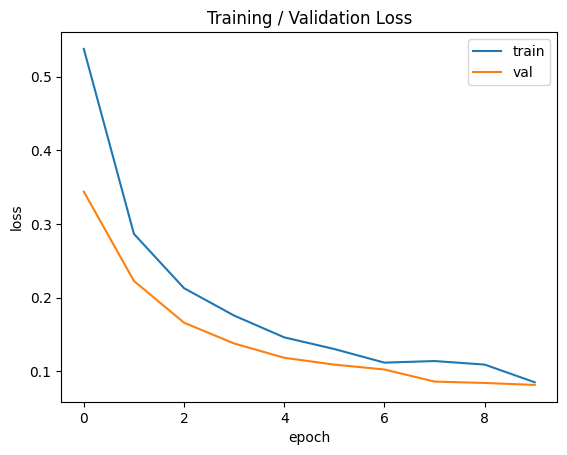

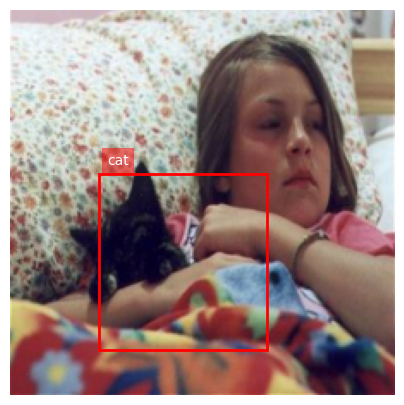

In [ ]:
plt.figure()
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.title("Training / Validation Loss")
plt.show()


def denormalize_img(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406], device=img_tensor.device).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225], device=img_tensor.device).view(3,1,1)
    return img_tensor * std + mean

def show_prediction(model, dataset, idx, label_map):
    model.eval()
    with torch.no_grad():
        img, bbox_true, label_true = dataset[idx]
        img_t = img.unsqueeze(0).to(device)
        pred = model(img_t)
        pred_bbox = pred["boxes"].squeeze(0).cpu().numpy()       # нормированные [0..1]
        pred_label = torch.argmax(pred["logits"], dim=1).item()

    img_denorm = denormalize_img(img).clamp(0,1)
    img_pil = to_pil_image(img_denorm.cpu())

    w, h = img_pil.size  # (224, 224) после Resize
    x1, y1, x2, y2 = pred_bbox
    x1, y1, x2, y2 = x1 * w, y1 * h, x2 * w, y2 * h

    # Используем существующую функцию визуализации
    bbox_dict = {"xmin": x1, "ymin": y1, "xmax": x2, "ymax": y2}
    show_image_with_bounding_box(img_denorm.cpu(), bbox_dict, label_map[pred_label])

def find_index_by_label(dataset, target_label):
    # target_label: int (0 или 1)
    for i in range(len(dataset)):
        _, _, lbl = dataset[i]
        if lbl == target_label:
            return i
    return None

cat_idx = find_index_by_label(ds_full, 0)
dog_idx = find_index_by_label(ds_full, 1)

if cat_idx is not None:
    show_prediction(model, ds_full, cat_idx, label_map)

<p class="task" id="6"></p>

6\. Найдите в сети несколько изображений котов и собак. Используя любой инструмент для разметки (например, [CVAT](https://www.cvat.ai/)), выделите котов и собак на изображениях. Вставьте скриншот экспортированного файла с разметкой. Используя полученные изображения, визуализируйте разметку и bounding boxes, полученные при помощи модели.

- [ ] Проверено на семинаре

Найдено 3 пар изображение-аннотация


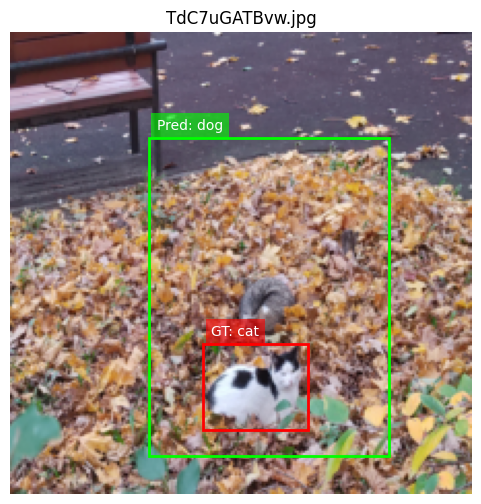

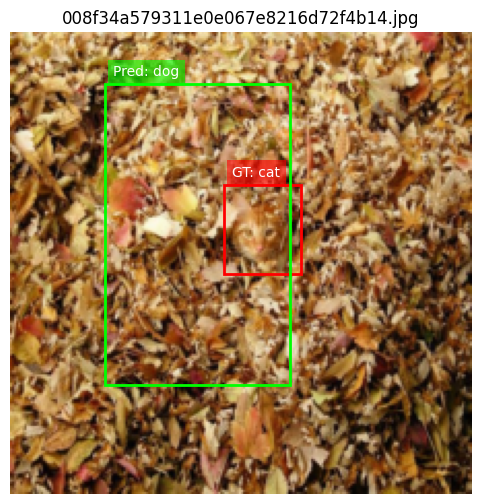

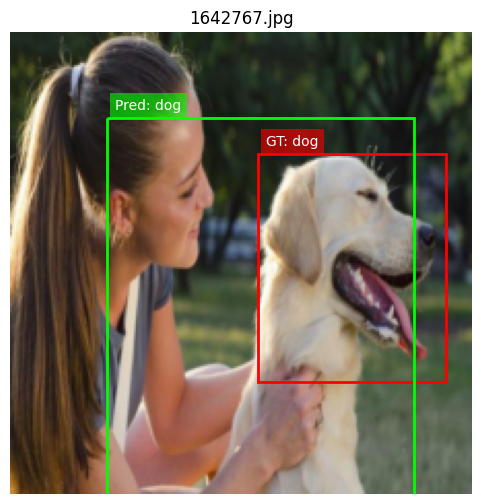

In [ ]:
def draw_box_px(ax, bbox_px, color, label=None):
    x1, y1, x2, y2 = bbox_px["xmin"], bbox_px["ymin"], bbox_px["xmax"], bbox_px["ymax"]
    rect = Rectangle((x1, y1), max(1, x2 - x1), max(1, y2 - y1), fill=False, edgecolor=color, linewidth=2)
    ax.add_patch(rect)
    if label:
        ax.text(x1 + 4, max(12, y1 - 4), label, color="white",
                bbox=dict(facecolor=color, alpha=0.6, edgecolor="none"))

def resize_raw_bbox_to(img_orig_size: Tuple[int, int], img_new_size: Tuple[int, int], raw_bbox: Dict[str, float]) -> Dict[str, float]:
    W0, H0 = img_orig_size
    Wn, Hn = img_new_size
    sx = Wn / W0
    sy = Hn / H0
    return {
        "xmin": raw_bbox["xmin"] * sx,
        "ymin": raw_bbox["ymin"] * sy,
        "xmax": raw_bbox["xmax"] * sx,
        "ymax": raw_bbox["ymax"] * sy,
    }

class TestImagesDataset(Dataset):
    def __init__(self, root="data/test_images", img_dir="Image", ann_dir="Annotations",
                 transforms_img: Optional[Callable] = None,
                 target_transform: Optional[Callable] = None):
        
        self.img_dir = os.path.join(root, img_dir)
        self.ann_dir = os.path.join(root, ann_dir)
        self.transforms_img = transforms_img
        self.target_transform = target_transform
        self.pairs = self._create_pairs()

    def _create_pairs(self):
        pairs = []
        xml_files = {}
        
        if os.path.exists(self.ann_dir):
            for file in os.listdir(self.ann_dir):
                if file.endswith('.xml'):
                    stem = os.path.splitext(file)[0]
                    xml_files[stem] = os.path.join(self.ann_dir, file)
        
        if os.path.exists(self.img_dir):
            for file in os.listdir(self.img_dir):
                stem, ext = os.path.splitext(file)
                if ext.lower() in ['.jpg', '.jpeg', '.png', '.bmp']:
                    if stem in xml_files:
                        img_path = os.path.join(self.img_dir, file)
                        xml_path = xml_files[stem]
                        pairs.append((img_path, xml_path))
        
        print(f"Найдено {len(pairs)} пар изображение-аннотация")
        return pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, xml_path = self.pairs[idx]
        ann = parse_xml(xml_path)

        img = Image.open(img_path).convert("RGB")
        orig_W, orig_H = img.size

        img_t = self.transforms_img(img) if self.transforms_img else TF.to_tensor(img)

        label = ann["obj_name"]
        if self.target_transform:
            label = self.target_transform(label)

        return img_t, ann["raw"], label, (orig_W, orig_H), img_path

ds_test = TestImagesDataset(root="data/test_images",
                            transforms_img=resnet_tfms,
                            target_transform=encode)

model = model.to(device).eval()

for i in range(len(ds_test)):
    img_t, raw_bbox, label, orig_size, img_path = ds_test[i]
    img_size = (img_t.shape[2], img_t.shape[1])

    bbox_resized = resize_raw_bbox_to(orig_size, img_size, raw_bbox)

    with torch.no_grad():
        pred = model(img_t.unsqueeze(0).to(device))
    
    pred_bbox_scaled = pred["boxes"][0].detach().cpu().tolist()
    pred_label_idx = pred["logits"].argmax(1).item()

    pred_bbox_px = {
        "xmin": pred_bbox_scaled[0] * img_size[0],
        "ymin": pred_bbox_scaled[1] * img_size[1],
        "xmax": pred_bbox_scaled[2] * img_size[0],
        "ymax": pred_bbox_scaled[3] * img_size[1],
    }

    img_denorm = denormalize_img(img_t.cpu())
    
    img_pil = to_pil_image(img_denorm)
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(img_pil)
    ax.axis("off")

    draw_box_px(ax, bbox_resized, "red", f"GT: {label_map[label] if isinstance(label, int) else label}")
 
    draw_box_px(ax, pred_bbox_px, "lime", f"Pred: {label_map.get(pred_label_idx, pred_label_idx)}")
    
    ax.set_title(os.path.basename(img_path))
    plt.show()